In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm_notebook

module_path = os.path.abspath(os.path.join('~/tmp/pycharm_project_17'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from tmp.pycharm_project_17.tests.models import autoencoder
from tmp.pycharm_project_17.cpc.utils import extractPatches, PictureDataset, EncodePatches, training, validation, AutoencodeImages

## Select Device

In [3]:
device = torch.device('cuda:1')

## Prepare Data

In [4]:
f = h5py.File('/home/data/imagenet/imagenet64.hdf5', 'r',libver='latest')

## Parameters

In [5]:
batch_size = 100
enc_size = 256

## Get Data

In [6]:
try:# Find mappings of imagenet subset if exists
    with open('./top-100-lables-indices-train.pickle', "br") as file:
        index_map = np.array(pickle.load(file))
        
    with open("./label_map.pickle", "br") as file:
        label_map = pickle.load(file)

except FileNotFoundError:
    print("file not found")
    index_map = None
    label_map = None
    
data = PictureDataset(f['train'], index_map=index_map, label_map=label_map)
dataloader = DataLoader(data, batch_size=batch_size)

## Prepare Training

In [7]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
weight_decay=1e-5)

## Training

In [8]:
try:
    # Load old training data if exists
    model.load_state_dict(torch.load("./trained_models/autoencoder.pth"))
    num_epochs = 0
    print("Restored Status")
except:
    num_epochs = 3


In [9]:
print_every = 10
running_loss = 0
all_losses = []
max_runs = len(dataloader)
# max_runs = 3

for epoch in range(num_epochs):
    for i, data in tqdm_notebook(
        enumerate (dataloader, 1),
        desc="Learning..",
        total=max_runs):
            
        img = data["image"].type(torch.FloatTensor).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % print_every == 0:
            avg_loss = running_loss / print_every
            all_losses.append(avg_loss)
            desc = "loss: %.3f" % (avg_loss)
            running_loss = 0.0  

        if i == max_runs:
            break


In [10]:
torch.save(model.state_dict(), "./trained_models/autoencoder.pth")

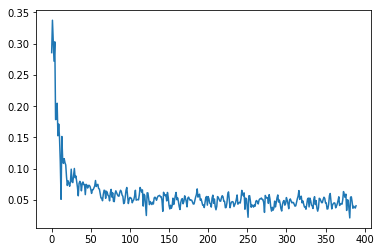

In [11]:
plt.plot(all_losses)

In [12]:
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (5): Tanh()
  )
)

In [13]:
img = next(iter(dataloader))["image"].type(torch.FloatTensor).to(device)

In [14]:
auto_img = model(img)

In [15]:
auto_img.shape

torch.Size([100, 3, 64, 64])

## Linear Class

In [16]:
classifier = nn.Linear(256, 100).to(device)
encoder = AutoencodeImages(model.encoder, 256, device)

In [17]:
all_losses = training(
    net=classifier,
    num_epochs=1,
    data_loader=dataloader,
    print_every=100,
    #max_runs=4000,
    device=device,
    criterion=nn.modules.CrossEntropyLoss().to(device),
    transform=encoder,
    tqdm=tqdm_notebook
)

In [18]:
torch.save(classifier.state_dict(), "./trained_models/autoencoder_classifier.pth")

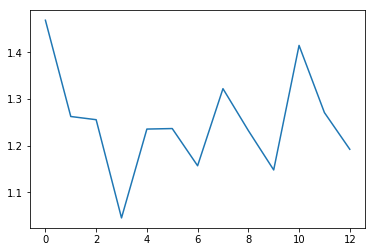

In [19]:
plt.plot(all_losses)

In [20]:
try:# Find mappings of imagenet subset if exists
    with open('./top-100-lables-indices-test.pickle', "br") as file:
        index_map = np.array(pickle.load(file))
        
    with open("./label_map.pickle", "br") as file:
        label_map = pickle.load(file)

except FileNotFoundError:
    print("file not found")
    index_map = None
    label_map = None
    
verify_data = PictureDataset(f['validation'], index_map=index_map, label_map=label_map)
verify_dataloader = DataLoader(verify_data, batch_size=batch_size)


In [21]:
validation(classifier, verify_dataloader, device=device, transform=encoder, tqdm=tqdm_notebook)

Accuracy of the network: 1 %
50


In [22]:
50/len(verify_data)

0.01